In [ ]:
# DO THIS BEFORE RUNNING ANYTHING ELSE
# Make sure to have Jupyter Notebook Extension downloaded too
# And Python I guess if you don't have it yet
# Then Open Terminal and make sure to be in the root/main directory of this project then run these codes:
# python -m venv .venv
# .\.venv\Scripts\activate
#
# Download the kaggle.json file and place it like on the main directory of this project folder.

In [ ]:
# Setup
# Alternative download in terminal using this code:
# pip install numpy pandas scikit-learn tensorflow transformers matplotlib seaborn kaggle

%pip install -q numpy pandas scikit-learn tensorflow transformers matplotlib seaborn kaggle

In [ ]:
# Downloading Dataset uWu

import os
import zipfile
from pathlib import Path

dataset_dir = Path('fake-and-real-news-dataset')  
kaggle_json = Path('kaggle.json')  

if not dataset_dir.exists():
    if not kaggle_json.exists():
        raise FileNotFoundError(
            "Please download kaggle.json from your Kaggle account and "
            f"place it in your project folder at: {Path.cwd()}"
        )
    
    kaggle_dir = Path.home() / '.kaggle'
    kaggle_dir.mkdir(exist_ok=True)
    
    import shutil
    shutil.copy(kaggle_json, kaggle_dir / 'kaggle.json')
    
    if os.name != 'nt': 
        os.chmod(kaggle_dir / 'kaggle.json', 0o600)
    
    import subprocess
    try:
        subprocess.run([
            'kaggle', 'datasets', 'download',
            '-d', 'clmentbisaillon/fake-and-real-news-dataset'
        ], check=True)
    except FileNotFoundError:
        raise RuntimeError(
            "Kaggle CLI not installed. Run: pip install kaggle"
        )
    
    zip_path = 'fake-and-real-news-dataset.zip'
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    
    os.remove(zip_path)
    print(f"✅ Dataset downloaded to: {dataset_dir.resolve()}")
else:
    print("✅ Dataset already exists")

In [ ]:
# Preprocessing

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

dataset_path = "./fake-and-real-news-dataset/"
fake_df = pd.read_csv(f'{dataset_path}Fake.csv')
true_df = pd.read_csv(f'{dataset_path}True.csv')

fake_df['label'] = 1  # 1 for fake news
true_df['label'] = 0  # 0 for real news
df = pd.concat([fake_df, true_df], axis=0)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['full_text'] = df['title'] + " " + df['text']

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\d+', '', text)       
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

df['clean_text'] = df['full_text'].apply(preprocess)
df = df[df['clean_text'].str.split().str.len() > 20].reset_index(drop=True)

X = df['clean_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

df['text_length'] = df['clean_text'].apply(len)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df['title_length'] = df['title'].apply(len)

df.to_csv('preprocessed_news.csv', index=False)
print(f"Dataset size: {len(df)} (Fake: {len(fake_df)}, Real: {len(true_df)})")

plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df)
plt.title('Class Distribution (0=Real, 1=Fake)')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50)
plt.title('Processed Text Length Distribution')
plt.show()

In [ ]:
# Feature Engineering Part

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, save_npz
import numpy as np
import joblib  # For saving scalers/vectorizers

# TF-IDF for traditional models (RF, Logistic Regression)
tfidf = TfidfVectorizer(max_features=10000, stop_words='english', 
                        ngram_range=(1, 3), sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

def get_metadata_features(df, indices):
    subset = df.loc[indices]
    features = np.vstack([
        np.log1p(subset['text_length']),  
        np.log1p(subset['word_count']),
        subset['title_length'] / 100,
        (subset['word_count'] / subset['text_length']) * 1000  
    ]).T
    return features

X_train_meta = get_metadata_features(df, X_train.index)
X_test_meta = get_metadata_features(df, X_test.index)

# Scale metadata features
meta_scaler = StandardScaler()
X_train_meta_scaled = meta_scaler.fit_transform(X_train_meta)
X_test_meta_scaled = meta_scaler.transform(X_test_meta)

# Save scaler for inference
joblib.dump(meta_scaler, 'meta_scaler.joblib')

# Combined features for traditional models
X_train_combined = hstack([X_train_tfidf, X_train_meta_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_meta_scaled])

print("✅ Feature engineering complete!")

In [ ]:
# Feature Importance Analysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

print("Running feature importance analysis...")

X_train_csr = X_train_combined.tocsr()

sample_size = min(5000, X_train_csr.shape[0])

X_train_dense = X_train_csr[:sample_size].toarray()

clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train_dense, y_train[:sample_size])

tfidf_feature_names = tfidf.get_feature_names_out()
meta_feature_names = ['log_text_length', 'log_word_count', 'scaled_title_length', 'word_density']
all_feature_names = np.concatenate([tfidf_feature_names, meta_feature_names])

importances = clf.feature_importances_
top_20_idx = importances.argsort()[::-1][:20]
top_20_names = [all_feature_names[i] for i in top_20_idx]
top_20_importances = importances[top_20_idx]

plt.figure(figsize=(12, 8))
plt.bar(range(20), top_20_importances, color='skyblue')
plt.xticks(range(20), top_20_names, rotation=90)
plt.title('Top 20 Important Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nTop 20 Features:")
for name, imp in zip(top_20_names, top_20_importances):
    print(f"{name}: {imp:.4f}")


In [ ]:
# Dimensionality Reduction (Truncated SVD)
from sklearn.decomposition import TruncatedSVD

print("Applying dimensionality reduction...")
svd = TruncatedSVD(n_components=500, random_state=42)
X_train_reduced = svd.fit_transform(X_train_combined)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(svd.explained_variance_ratio_), 'b-', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Truncated SVD: Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.savefig('svd_variance.png')
plt.show()

print(f"Components needed for 95% variance: {np.argmax(np.cumsum(svd.explained_variance_ratio_) >= 0.95) + 1}")

In [ ]:
# Save datasets for different model types

# For traditional models
save_npz('X_train_traditional.npz', X_train_combined)
save_npz('X_test_traditional.npz', X_test_combined)

# For deep learning models (save raw text + metadata)
np.save('X_train_text.npy', X_train.values)
np.save('X_test_text.npy', X_test.values)
np.save('X_train_meta.npy', X_train_meta)
np.save('X_test_meta.npy', X_test_meta)

# Labels
np.save('y_train.npy', y_train.values)
np.save('y_test.npy', y_test.values)

# Save full metadata for later use
df[['clean_text', 'text_length', 'word_count', 'title_length', 'label']].to_csv(
    'full_processed_data.csv', index=False
)

print("✅ Dataset saving complete!")

In [3]:
# Logistic Regression
import time
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.sparse import load_npz
import numpy as np
import joblib

X_train_combined = load_npz('X_train_traditional.npz')
X_test_combined  = load_npz('X_test_traditional.npz')
y_train          = np.load('y_train.npy')
y_test           = np.load('y_test.npy')

lr = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced',
    solver='saga',
    penalty='elasticnet',
    l1_ratio=0.5
)
lr.fit(X_train_combined, y_train)

joblib.dump(lr, 'lr_model.joblib')
lr_size = os.path.getsize('lr_model.joblib') / (1024 * 1024)  # size in MB

inference_times = {}

start = time.time()
lr_pred = lr.predict(X_test_combined)
inference_times['Logistic Regression (predict)'] = (time.time() - start) / len(y_test)

start = time.time()
lr_probs = lr.predict_proba(X_test_combined)[:, 1]
inference_times['Logistic Regression (predict_proba)'] = (time.time() - start) / len(y_test)

np.save('logistic_regression_probs.npy', lr_probs)

print("Logistic Regression Performance:")
print(f"  Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"  F1 Score: {f1_score(y_test, lr_pred, average='weighted'):.4f}")
print(classification_report(y_test, lr_pred, target_names=['Real', 'Fake']))

print("\nInference time per sample (s):")
for name, t in inference_times.items():
    print(f"  {name}: {t:.6f}")
print(f"\nModel file size: {lr_size:.2f} MB")

Logistic Regression Performance:
  Accuracy: 0.9935
  F1 Score: 0.9935
              precision    recall  f1-score   support

        Real       0.99      1.00      0.99      4283
        Fake       1.00      0.99      0.99      4547

    accuracy                           0.99      8830
   macro avg       0.99      0.99      0.99      8830
weighted avg       0.99      0.99      0.99      8830


Inference time per sample (s):
  Logistic Regression (predict): 0.000003
  Logistic Regression (predict_proba): 0.000003

Model file size: 0.08 MB


In [4]:
# Random Forest

import time
import os
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

try:
    X_train = np.load('X_train_reduced.npy')
    X_test  = np.load('X_test_reduced.npy')
    print("Using reduced features")
except FileNotFoundError:
    from scipy.sparse import load_npz
    X_train = load_npz('X_train_traditional.npz')
    X_test  = load_npz('X_test_traditional.npz')
    print("Using full features")

y_train = np.load('y_train.npy')
y_test  = np.load('y_test.npy')

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rf.fit(X_train, y_train)

joblib.dump(rf, 'random_forest_model.joblib')
rf_size = os.path.getsize('random_forest_model.joblib') / (1024 * 1024)  # MB

inference_times = {}

start = time.time()
rf_pred = rf.predict(X_test)
inference_times['Random Forest (predict)'] = (time.time() - start) / len(y_test)

start = time.time()
rf_probs = rf.predict_proba(X_test)[:, 1]
inference_times['Random Forest (predict_proba)'] = (time.time() - start) / len(y_test)

np.save('random_forest_probs.npy', rf_probs)

print("\nRandom Forest Performance:")
print(f"  Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"  F1 Score: {f1_score(y_test, rf_pred, average='weighted'):.4f}")
print(classification_report(y_test, rf_pred, target_names=['Real', 'Fake']))

print("\nInference time per sample (s):")
for name, t in inference_times.items():
    print(f"  {name}: {t:.6f}")
print(f"\nModel file size: {rf_size:.2f} MB")


Using full features


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s



Random Forest Performance:
  Accuracy: 0.9983
  F1 Score: 0.9983
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4283
        Fake       1.00      1.00      1.00      4547

    accuracy                           1.00      8830
   macro avg       1.00      1.00      1.00      8830
weighted avg       1.00      1.00      1.00      8830


Inference time per sample (s):
  Random Forest (predict): 0.000094
  Random Forest (predict_proba): 0.000118

Model file size: 41.84 MB


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.9s finished


In [5]:
# LSTM

import os
import time
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, f1_score, classification_report

X_train_text = np.load('X_train_text.npy', allow_pickle=True)
X_test_text  = np.load('X_test_text.npy', allow_pickle=True)
y_train      = np.load('y_train.npy')
y_test       = np.load('y_test.npy')

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train_text)
with open('lstm_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

max_len     = 200
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len)

model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=max_len, mask_zero=True),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=False)),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_lstm_model.keras', save_best_only=True)
]

history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=256,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

model = load_model('best_lstm_model.keras')

inference_times = {}
start_time = time.time()

lstm_pred_raw = model.predict(X_test_pad)
lstm_pred = (lstm_pred_raw > 0.5).astype(int)
total_time = time.time() - start_time

lstm_time = total_time / len(y_test)
inference_times['LSTM'] = lstm_time
print(f"LSTM inference time per sample: {lstm_time:.6f} sec")

print("\nLSTM Performance:")
print(f"Accuracy: {accuracy_score(y_test, lstm_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, lstm_pred, average='weighted'):.4f}")
print(classification_report(y_test, lstm_pred, target_names=['Real', 'Fake']))

model.save('lstm_model.keras')
lstm_size = os.path.getsize('lstm_model.keras') / (1024 * 1024)
print(f"LSTM model file size: {lstm_size:.2f} MB")

print("\nSummary:")
print("Inference times:", inference_times)
print(f"Model sizes (MB): {{'LSTM': {lstm_size:.2f}}}")

c:\Users\renor\Downloads\C20FinalProject\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.8081 - loss: 0.9878 - val_accuracy: 0.9779 - val_loss: 0.1851
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.9817 - loss: 0.1391 - val_accuracy: 0.9855 - val_loss: 0.0650
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.9917 - loss: 0.0522 - val_accuracy: 0.9877 - val_loss: 0.0549
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.9953 - loss: 0.0327 - val_accuracy: 0.9860 - val_loss: 0.0545
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9904 - loss: 0.0430 - val_accuracy: 0.9832 - val_loss: 0.0682
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9944 - loss: 0.0317 - val_accuracy: 0.9898 - val_loss: 0.0530
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9982 - loss: 0.0181 - val_accuracy: 0.9902 - val_loss: 0.0502
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9990 - loss: 0.0129 - val_accu

In [2]:
import subprocess
import sys
import importlib
import os
import time
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers.optimization_tf import create_optimizer
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Configuring hardware acceleration...")
if tf.config.list_physical_devices('GPU'):
    print("NVIDIA GPU detected - using CUDA acceleration")
else:
    
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
    print("No NVIDIA GPU detected - using CPU/AMD optimization")
    
   
    os.environ['OMP_NUM_THREADS'] = str(os.cpu_count())
    os.environ['TF_NUM_INTEROP_THREADS'] = str(os.cpu_count())
    os.environ['TF_NUM_INTRAOP_THREADS'] = str(os.cpu_count())
    tf.config.threading.set_inter_op_parallelism_threads(os.cpu_count())
    tf.config.threading.set_intra_op_parallelism_threads(os.cpu_count())

try:
    import tf_keras as keras
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tf-keras"])
    import tf_keras as keras

from tf_keras.callbacks import EarlyStopping, Callback

class SavePretrainedCallback(Callback):
    def __init__(self, output_dir, monitor='val_loss', mode='min'):
        super().__init__()
        self.output_dir = output_dir
        self.monitor = monitor
        self.mode = mode
        self.best = np.inf if mode == 'min' else -np.inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        if (self.mode == 'min' and current < self.best) or \
           (self.mode == 'max' and current > self.best):
            self.best = current
            self.model.save_pretrained(self.output_dir)
            print(f"\nSaved best model to {self.output_dir} with {self.monitor} = {current:.5f}")

print("Loading datasets...")
X_train_text = np.load('X_train_text.npy', allow_pickle=True)
X_test_text  = np.load('X_test_text.npy', allow_pickle=True)
y_train      = np.load('y_train.npy')
y_test       = np.load('y_test.npy')

print("Initializing tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def batch_tokenize(texts, tokenizer, batch_size=500): 
    encodings = {'input_ids': [], 'attention_mask': []}
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size].tolist()
        batch_enc = tokenizer(
            batch,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors="tf"
        )
        encodings['input_ids'].append(batch_enc['input_ids'])
        encodings['attention_mask'].append(batch_enc['attention_mask'])
    return {
        'input_ids': tf.concat(encodings['input_ids'], axis=0),
        'attention_mask': tf.concat(encodings['attention_mask'], axis=0)
    }

print("Tokenizing training data...")
train_encodings = batch_tokenize(X_train_text, tokenizer)
print("Tokenizing test data...")
test_encodings  = batch_tokenize(X_test_text, tokenizer)

print("Creating datasets...")
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_encodings,
    y_train
)).shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)  

test_dataset = tf.data.Dataset.from_tensor_slices((
    test_encodings,
    y_test
)).batch(8).prefetch(tf.data.AUTOTUNE)

print("Initializing model...")
model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

num_train_steps = len(train_dataset) * 3
optimizer, lr_schedule = create_optimizer(
    init_lr=3e-5,
    num_warmup_steps=500,
    num_train_steps=num_train_steps
)

print("Compiling model...")
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=2, restore_best_weights=True),
    SavePretrainedCallback('best_distilbert_model', monitor='val_loss')
]

print("\nStarting training...")
print(f"Using device: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'} with {os.cpu_count()} threads")
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

print("Loading best model for evaluation...")
model = TFDistilBertForSequenceClassification.from_pretrained('best_distilbert_model')

print("\nMeasuring inference performance...")
start_time = time.time()
pred_output = model.predict(test_dataset, batch_size=8)  
total_time = time.time() - start_time

num_samples = len(y_test)
distilbert_time = total_time / num_samples
inference_times = {'DistilBERT': distilbert_time}
print(f"\nInference time per sample: {distilbert_time:.6f} sec")

bert_pred = np.argmax(pred_output.logits, axis=1)

print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy_score(y_test, bert_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, bert_pred, average='weighted'):.4f}")
print(classification_report(y_test, bert_pred, target_names=['Real', 'Fake']))

print("Saving final model...")
model.save_pretrained('distilbert_model')
tokenizer.save_pretrained('distilbert_tokenizer')

def folder_size_mb(folder):
    total = 0
    for dirpath, _, filenames in os.walk(folder):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total += os.path.getsize(fp)
    return total / (1024 * 1024)

distilbert_size = folder_size_mb('distilbert_model')
print(f"Model size: {distilbert_size:.2f} MB")

print("\nTraining Summary:")
print(f"System: {'AMD Radeon' if not tf.config.list_physical_devices('GPU') else 'NVIDIA GPU'}")
print(f"Processor: {os.cpu_count()} cores")
print("Inference times:", inference_times)
print(f"Model size: {distilbert_size:.2f} MB")

Configuring hardware acceleration...
No NVIDIA GPU detected - using CPU/AMD optimization
Loading datasets...
Initializing tokenizer...
Tokenizing training data...
Tokenizing test data...
Creating datasets...
Initializing model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Compiling model...

Starting training...
Using device: CPU with 4 threads
Epoch 1/3


4415/4415 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9898
Saved best model to best_distilbert_model with val_loss = 0.00680
4415/4415 [==============================] - 28532s 6s/step - loss: 0.0285 - accuracy: 0.9898 - val_loss: 0.0068 - val_accuracy: 0.9983
Epoch 2/3
4415/4415 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9993
Saved best model to best_distilbert_model with val_loss = 0.00409
4415/4415 [==============================] - 28350s 6s/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0041 - val_accuracy: 0.9991
Epoch 3/3
4415/4415 [==============================] - ETA: 0s - loss: 7.2416e-04 - accuracy: 0.9999
Saved best model to best_distilbert_model with val_loss = 0.00332
4415/4415 [==============================] - 28274s 6s/step - loss: 7.2416e-04 - accuracy: 0.9999 - val_loss: 0.0033 - val_accuracy: 0.9993
Loading best model 

Some layers from the model checkpoint at best_distilbert_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at best_distilbert_model and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Measuring inference performance...
1104/1104 [==============================] - 2534s 2s/step

Inference time per sample: 0.287089 sec

Performance Metrics:
Accuracy: 0.9993
F1 Score: 0.9993
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4283
        Fake       1.00      1.00      1.00      4547

    accuracy                           1.00      8830
   macro avg       1.00      1.00      1.00      8830
weighted avg       1.00      1.00      1.00      8830

Saving final model...
Model size: 255.54 MB

Training Summary:
System: AMD Radeon
Processor: 4 cores
Inference times: {'DistilBERT': 0.2870885717504292}
Model size: 255.54 MB


C:\Users\renor\AppData\Local\Temp\ipykernel_9832\923924274.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='F1 Score', data=results_df,
C:\Users\renor\AppData\Local\Temp\ipykernel_9832\923924274.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Time (s)', data=times_df,


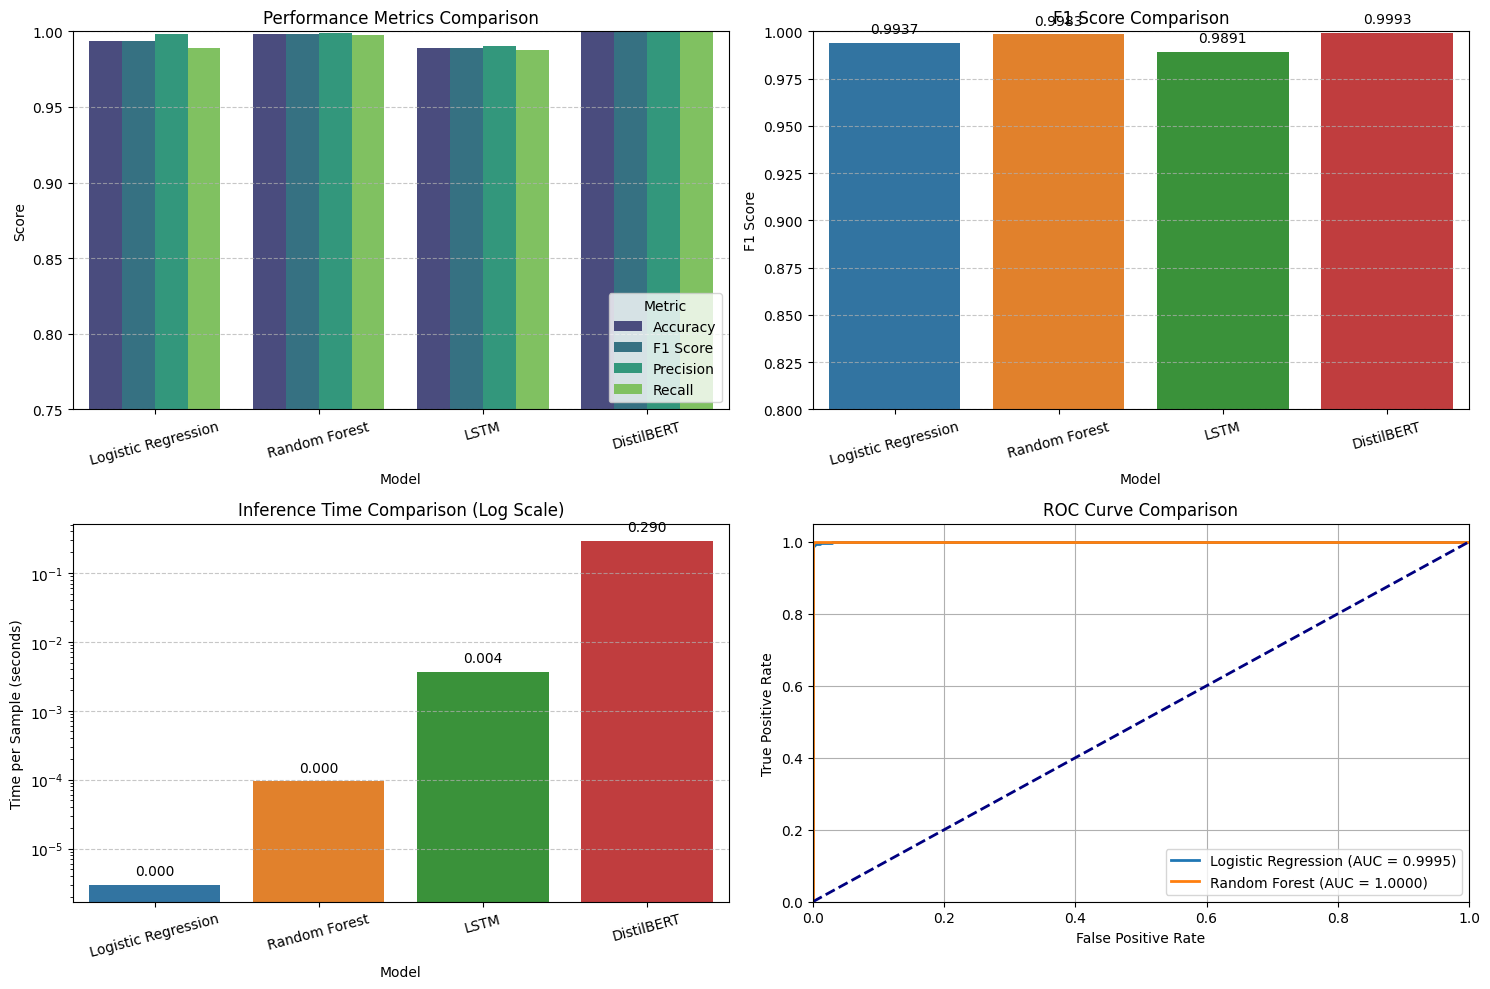

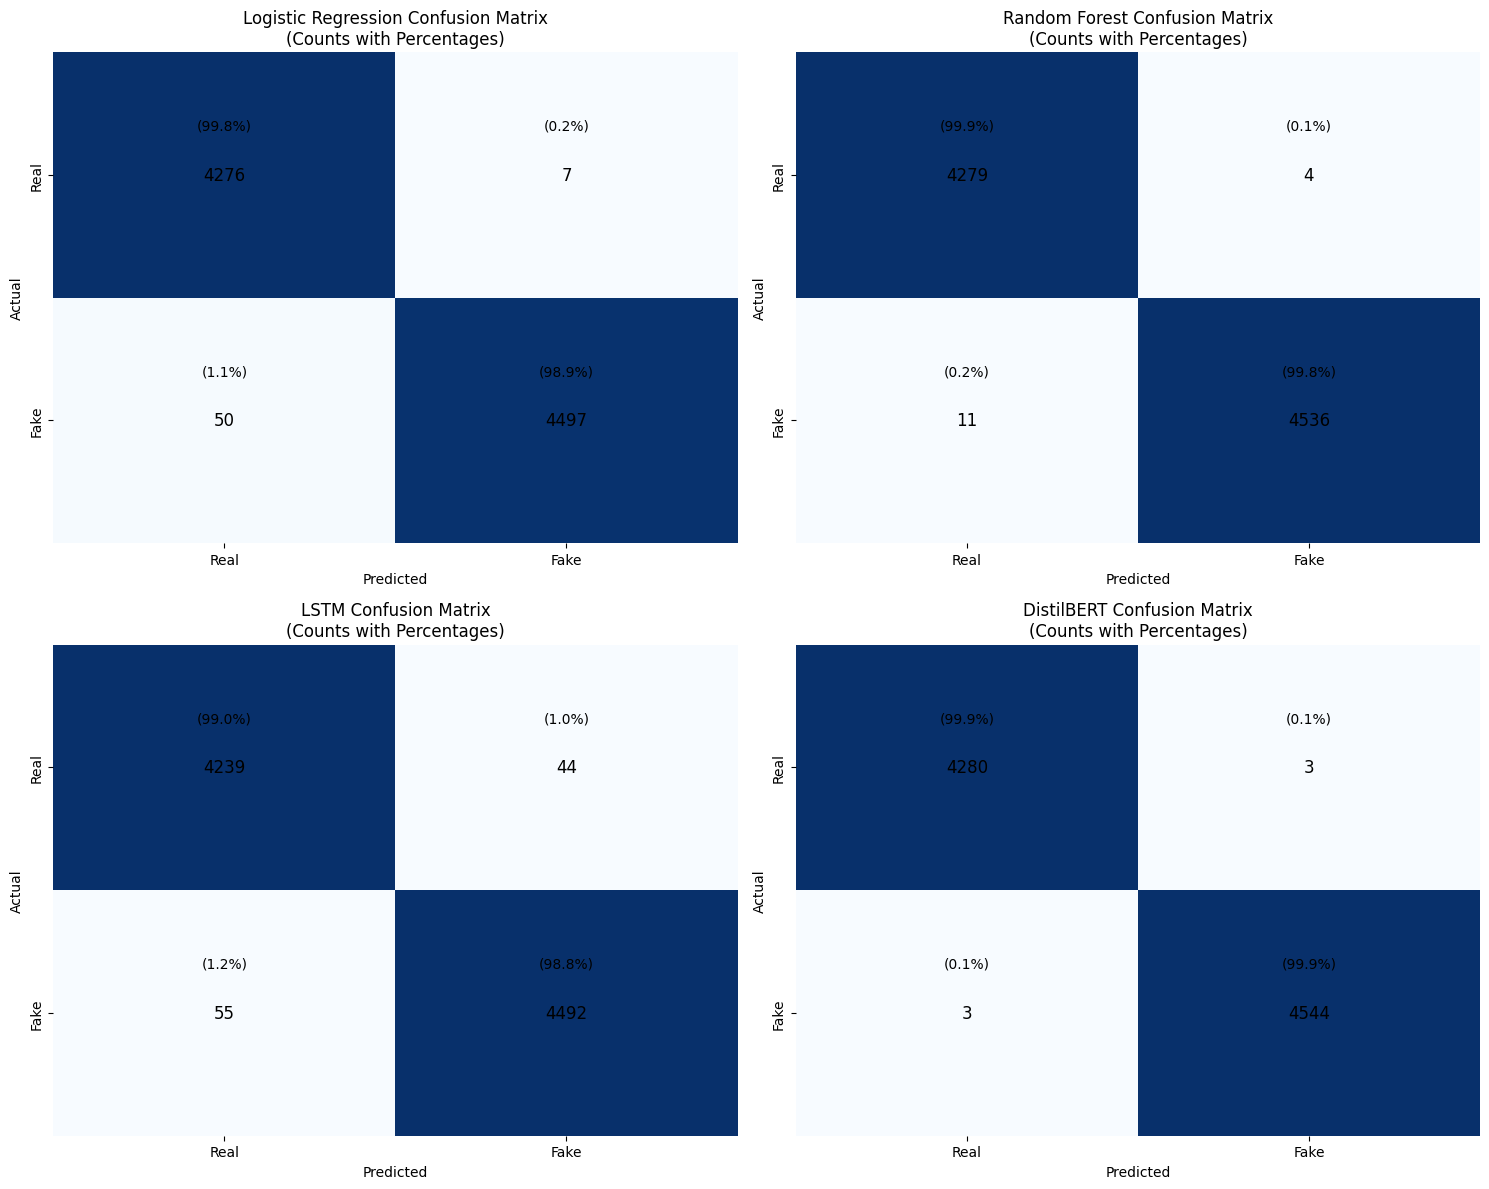


MODEL COMPARISON SUMMARY
                 Model  Accuracy  F1 Score  Precision    Recall
0  Logistic Regression  0.993545  0.993702   0.998446  0.989004
1        Random Forest  0.998301  0.998349   0.999119  0.997581
2                 LSTM  0.988788  0.989101   0.990300  0.987904
3           DistilBERT  0.999320  0.999340   0.999340  0.999340


C:\Users\renor\AppData\Local\Temp\ipykernel_9832\923924274.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Size (MB)', data=sizes_df, palette=MODEL_COLORS.values())


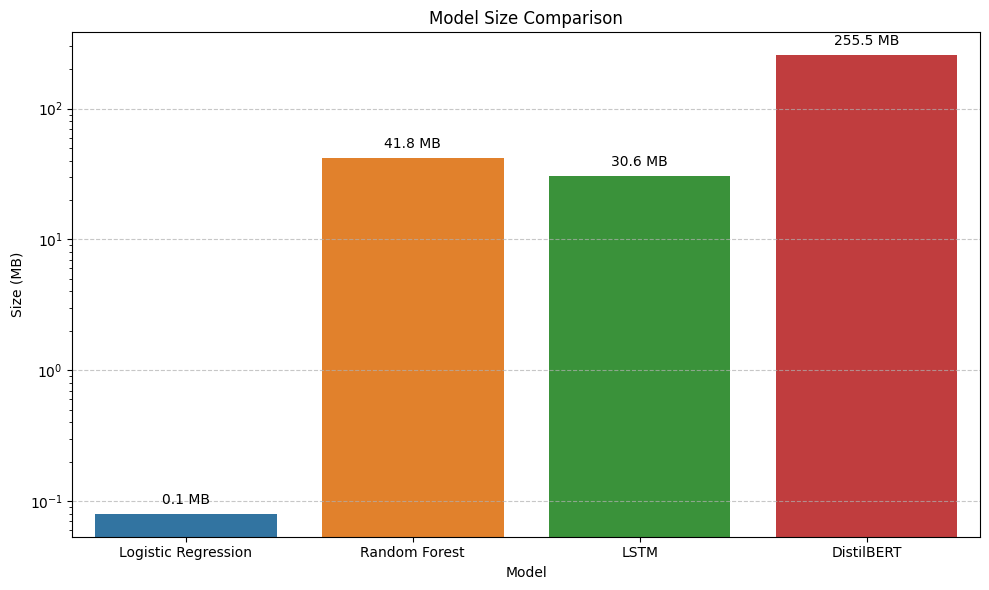

In [6]:
# Results and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, f1_score, precision_score, 
                            recall_score, confusion_matrix, classification_report,
                            roc_curve, auc, RocCurveDisplay)

MODEL_COLORS = {
    'Logistic Regression': '#1f77b4',
    'Random Forest': '#ff7f0e',
    'LSTM': '#2ca02c',
    'DistilBERT': '#d62728'
}

# 1. Enhanced Results Collection ===============================================
results = []
classification_reports = {}

models = [
    ('Logistic Regression', lr_pred),
    ('Random Forest', rf_pred),
    ('LSTM', lstm_pred.flatten()),
    ('DistilBERT', bert_pred)
]

for name, pred in models:
    # Calculate metrics
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'Precision': prec,
        'Recall': rec
    })
    
    # Store full classification report
    classification_reports[name] = classification_report(
        y_test, pred, target_names=['Real', 'Fake'], output_dict=True
    )

# Create results dataframe
results_df = pd.DataFrame(results)

# 2. Model Comparison Visualization ============================================
plt.figure(figsize=(15, 10))

# Metrics Comparison (Grouped Bar Plot)
metrics_df = results_df.melt(id_vars='Model', 
                             value_vars=['Accuracy', 'F1 Score', 'Precision', 'Recall'],
                             var_name='Metric', value_name='Score')

plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df, palette='viridis')
plt.title('Performance Metrics Comparison')
plt.ylim(0.75, 1.0)
plt.legend(title='Metric', loc='lower right')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# F1 Score Comparison
plt.subplot(2, 2, 2)
ax = sns.barplot(x='Model', y='F1 Score', data=results_df, 
                 palette=MODEL_COLORS.values())
plt.title('F1 Score Comparison')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Inference Time Comparison (Values Placeholder uWu, look outputs and manually edit)
inference_times = {
    'Logistic Regression': 0.000003,
    'Random Forest': 0.000094,
    'LSTM': 0.0036,
    'DistilBERT': 0.29
}
times_df = pd.DataFrame(list(inference_times.items()), columns=['Model', 'Time (s)'])

plt.subplot(2, 2, 3)
ax = sns.barplot(x='Model', y='Time (s)', data=times_df, 
                 palette=MODEL_COLORS.values(), log=True)
plt.title('Inference Time Comparison (Log Scale)')
plt.ylabel('Time per Sample (seconds)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# ROC Curve Comparison (Only for models that support probabilities)
plt.subplot(2, 2, 4)
for name, _ in models:
    if name in ['Logistic Regression', 'Random Forest']:
        # Load probability predictions (you need to generate these during model training)
        probs = np.load(f'{name.replace(" ", "_").lower()}_probs.npy')
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, 
                 label=f'{name} (AUC = {roc_auc:.4f})',
                 color=MODEL_COLORS[name])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('model_comparison_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Confusion Matrix Visualization ===========================================
plt.figure(figsize=(15, 12))
for i, (name, pred) in enumerate(models, 1):
    cm = confusion_matrix(y_test, pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages
    
    plt.subplot(2, 2, i)
    sns.heatmap(cm_percent, annot=cm, fmt='d',
                cmap='Blues', cbar=False,
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'],
                annot_kws={'fontsize': 12, 'color': 'black'})
    
    # Add percentage annotations
    for i in range(2):
        for j in range(2):
            plt.text(j+0.5, i+0.3, f'({cm_percent[i, j]:.1f}%)', 
                     ha='center', va='center', color='black', fontsize=10)
    
    plt.title(f'{name} Confusion Matrix\n(Counts with Percentages)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Detailed Classification Reports ==========================================
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(results_df)

# Save detailed reports
with open('classification_reports.txt', 'w') as f:
    for name, report in classification_reports.items():
        f.write(f"\n{'='*40}\n")
        f.write(f"{name} Classification Report\n")
        f.write('='*40 + "\n")
        f.write(classification_report(
            y_test, 
            next(pred for model_name, pred in models if model_name == name),
            target_names=['Real', 'Fake']
        ))
        f.write("\n")

# Save results to CSV
results_df.to_csv('model_results.csv', index=False)

# 5. Additional: Model Size Comparison (Manual Input, Values Placeholder uWu)========================================
model_sizes = {
    'Logistic Regression': 0.08,  # MB
    'Random Forest': 41.84,       # MB
    'LSTM': 30.57,                 # MB
    'DistilBERT': 255.54          # MB
}

plt.figure(figsize=(10, 6))
sizes_df = pd.DataFrame(list(model_sizes.items()), columns=['Model', 'Size (MB)'])
ax = sns.barplot(x='Model', y='Size (MB)', data=sizes_df, palette=MODEL_COLORS.values())
plt.title('Model Size Comparison')
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f} MB', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.savefig('model_size_comparison.png', dpi=300, bbox_inches='tight')
plt.show()